In [1]:
#Importing libraries
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import requests
pd.options.mode.chained_assignment = None
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from datetime import datetime
from wordcloud import WordCloud,STOPWORDS
import sqlite3
import pandas as pd

In [2]:
# Connect to SQLite database
conn = sqlite3.connect('reddit_data.db')

# Query to select all data from the reddit_posts table
query = "SELECT * FROM reddit_posts"

# Read data from the database into a DataFrame
data = pd.read_sql_query(query, conn)

# Close connection
conn.close()

# Display the DataFrame
data.head()

,id,subreddit,title,selftext,upvote_ratio,ups,downs,score,link_flair_css_class,created_utc,kind,cleaned
0,1,politics,Trump Jokes About How Longtime Aide Could End ...,,1.00,3,0,3,None,2024-04-12T09:54:31Z,t3,None
1,2,politics,US to probe if Chinese cars pose national data...,,1.00,4,0,4,None,2024-04-12T09:41:11Z,t3,None
2,3,politics,Irish taoiseach and Spanish PM to discuss Pale...,,0.54,1,0,1,None,2024-04-12T09:09:41Z,t3,None
3,4,politics,Why Trump’s ‘hush money’ case is bigger than h...,,0.94,15,0,15,None,2024-04-12T09:01:51Z,t3,None
4,5,politics,1864 AZ Speaker of the house who helped pass t...,,0.86,35,0,35,None,2024-04-12T08:20:41Z,t3,None


In [3]:
data.shape

(993, 12)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 993 entries, 0 to 992
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   id                    993 non-null    int64  
 1   subreddit             993 non-null    object 
 2   title                 993 non-null    object 
 3   selftext              993 non-null    object 
 4   upvote_ratio          993 non-null    float64
 5   ups                   993 non-null    int64  
 6   downs                 993 non-null    int64  
 7   score                 993 non-null    int64  
 8   link_flair_css_class  7 non-null      object 
 9   created_utc           993 non-null    object 
 10  kind                  993 non-null    object 
 11  cleaned               0 non-null      object 
dtypes: float64(1), int64(4), object(7)
memory usage: 93.2+ KB


In [5]:
data.selftext

0       
1       
2       
3       
4       
      ..
988     
989     
990     
991     
992     
Name: selftext, Length: 993, dtype: object

I extracted the text from the 'title' column of the data and used the WordCloud library to generate the word cloud. 

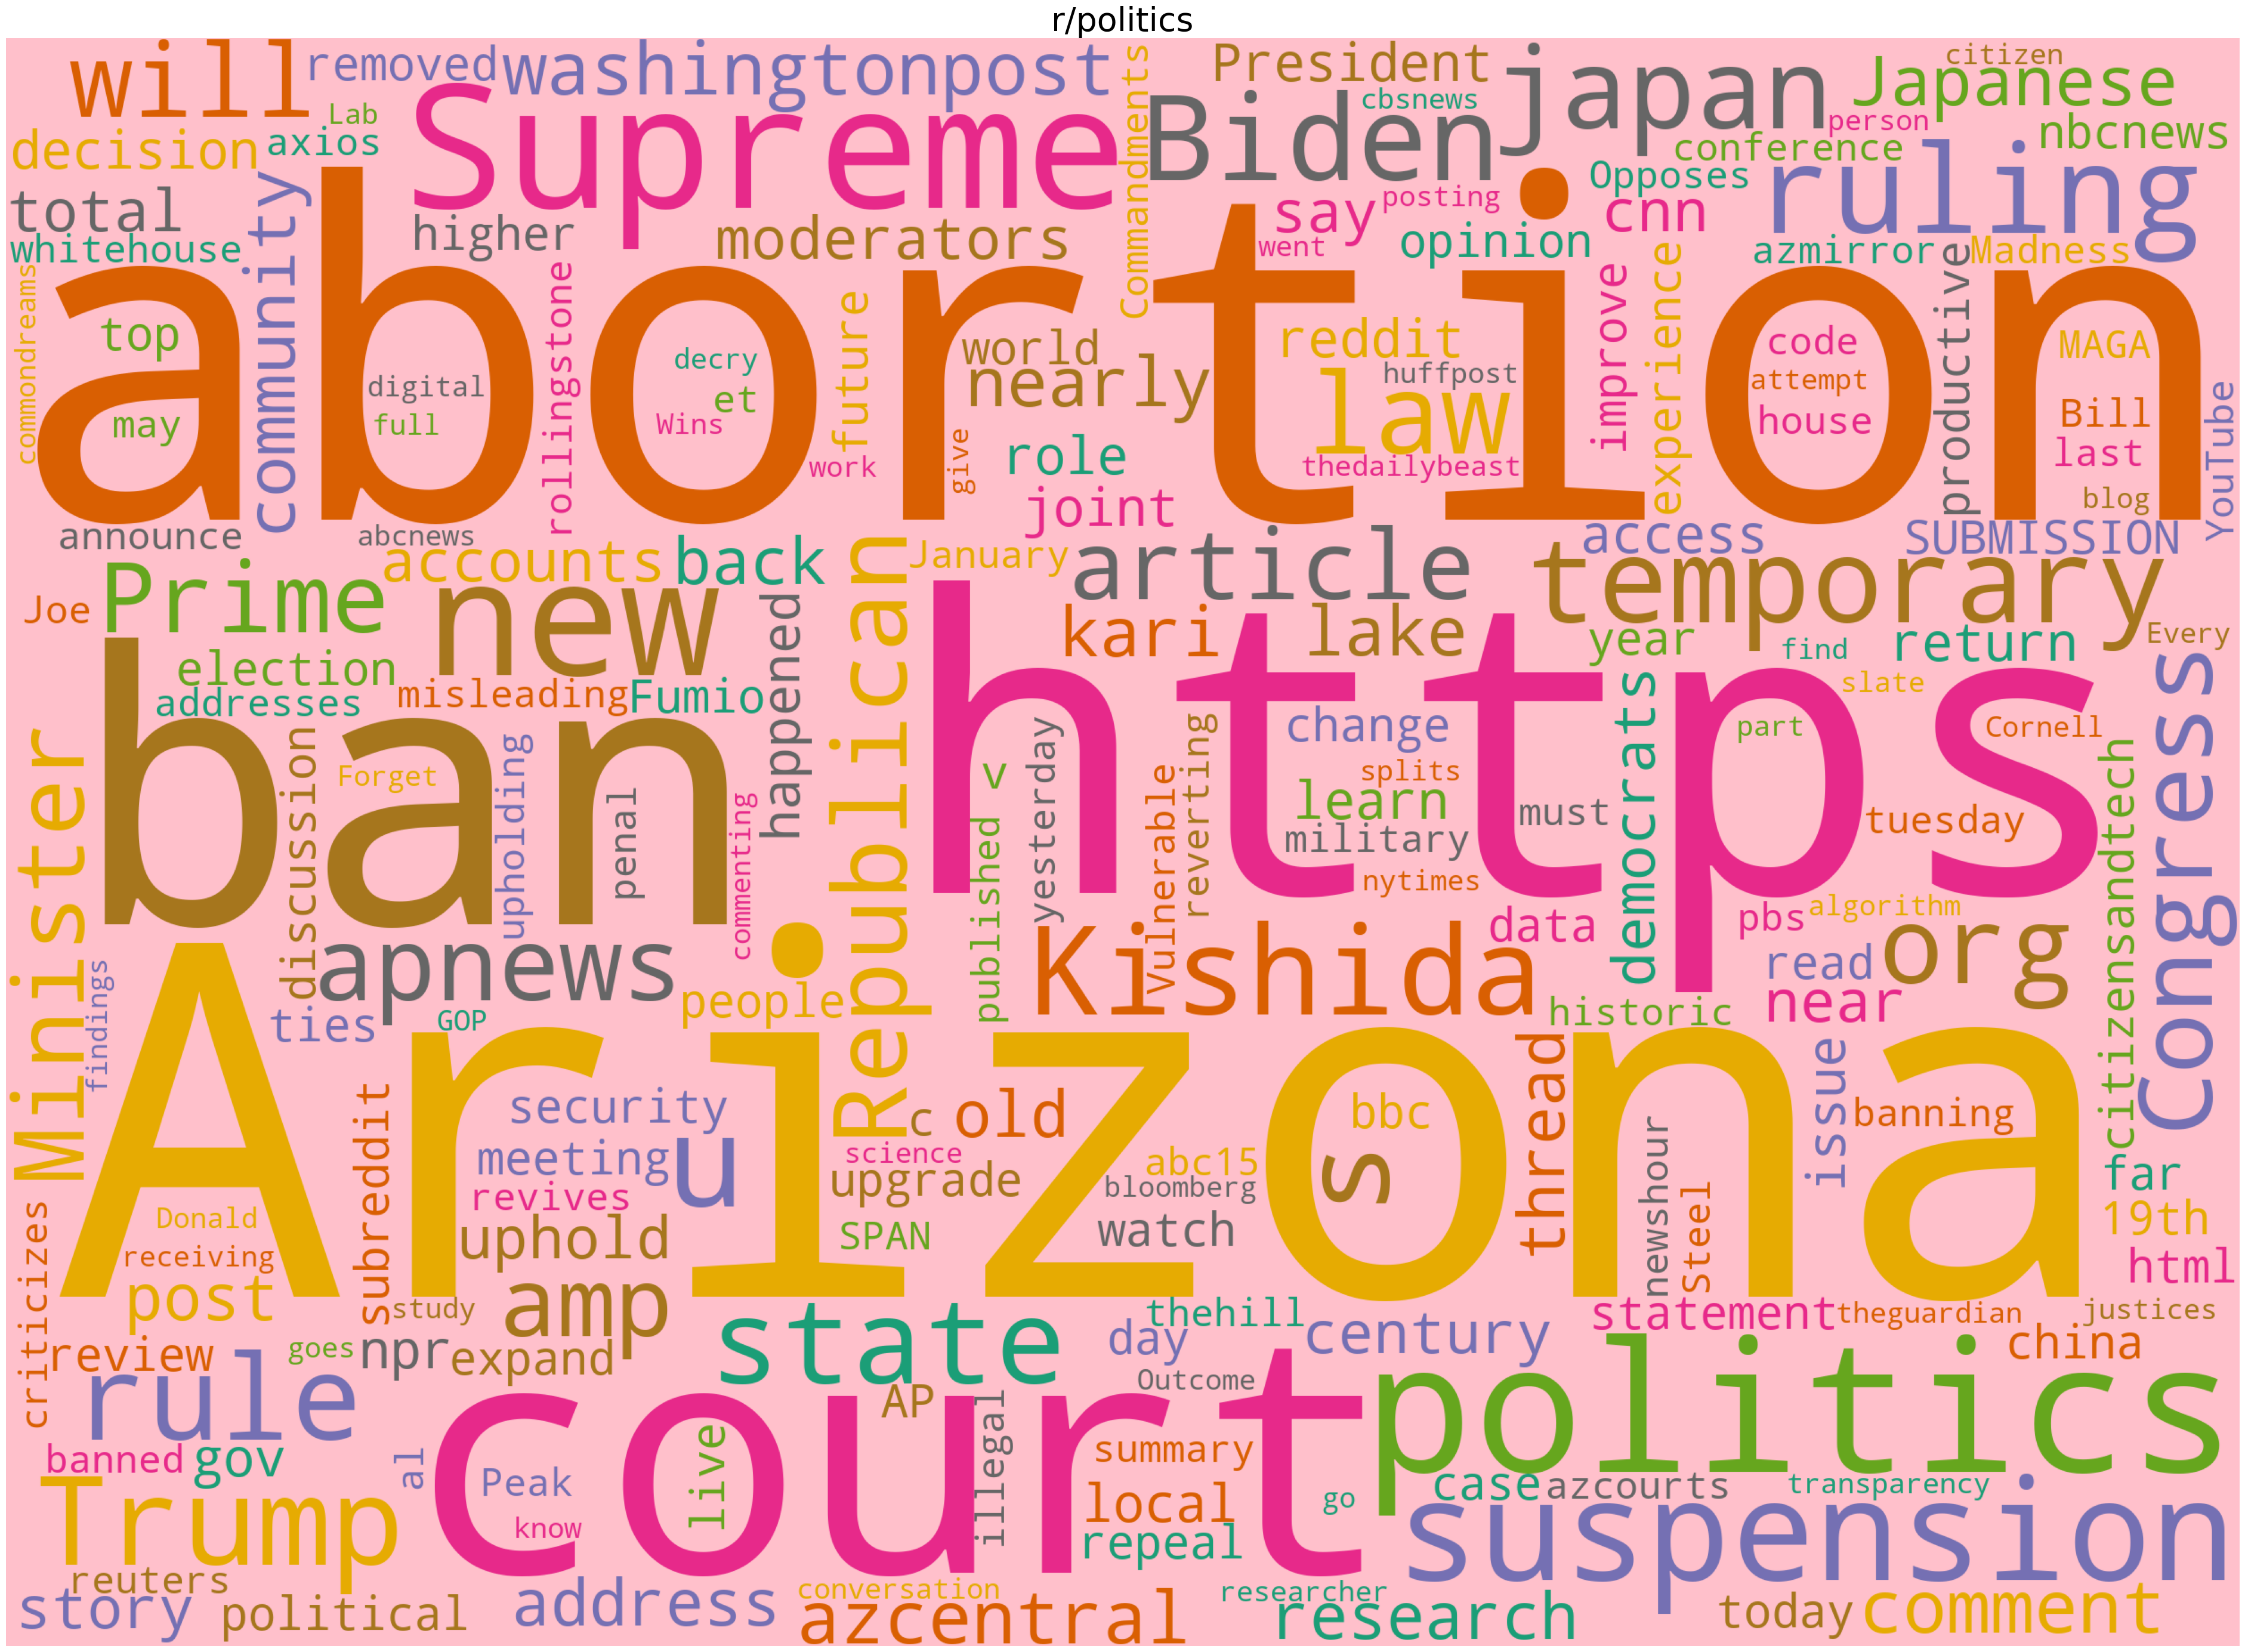

In [6]:
plt.figure(figsize=(60,35))
#subset = data['title']
text = data['selftext'].values
cloud1=WordCloud(stopwords=STOPWORDS,background_color='pink',colormap="Dark2",collocations=False,width=2500,height=1800).generate(" ".join(text))
plt.axis('off')
plt.title("r/politics",fontsize=40)
plt.imshow(cloud1)

As we can see from the word cloud, the main themes are around recent developments relating to Abortion, bans and Arizona, mostly US politics heavy.

In [7]:
import nltk
# nltk.download('stopwords')
# nltk.download('wordnet')
from nltk.corpus import stopwords
from string import punctuation

# stop = set(stopwords.words('english'))

In [8]:
stop = set(STOPWORDS)

In [10]:
import re

def lower(text):
    return text.lower()

def remove_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in stop])

def remove_punctuation(text):
    return text.translate(str.maketrans('','', punctuation))

def clean_text(text):
    text = lower(text)
    text = remove_stopwords(text)
    text = remove_punctuation(text)
    return text

#Apply function on column
data['cleaned']=data['title'].apply(clean_text)

In [11]:
data['cleaned'].head()

0           trump jokes longtime aide end career flash
1    us probe chinese cars pose national data secur...
2    irish taoiseach spanish pm discuss palestine n...
3          trump’s ‘hush money’ case bigger hush money
4    1864 az speaker house helped pass abortion law...
Name: cleaned, dtype: object

In [12]:
from collections import Counter
cnt=Counter()

for text in data['cleaned'].values:
    for word in text.split():
        cnt[word]+=1
        
cnt.most_common(10)

[('trump', 245),
 ('biden', 154),
 ('abortion', 97),
 ('says', 94),
 ('us', 80),
 ('new', 60),
 ('donald', 52),
 ('election', 52),
 ('trump’s', 49),
 ('house', 49)]

In [13]:
FREQWORDS = set([w for (w, wc) in cnt.most_common(10)])
def remove_freqwords(text):
    return " ".join([word for word in str(text).split() if word not in FREQWORDS])

data['cleaned'] = data['cleaned'].apply(lambda text: remove_freqwords(text))

In [15]:
data['cleaned'].head()

0                 jokes longtime aide end career flash
1    probe chinese cars pose national data security...
2    irish taoiseach spanish pm discuss palestine n...
3                  ‘hush money’ case bigger hush money
4    1864 az speaker helped pass law 5 very young w...
Name: cleaned, dtype: object

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, # sublinear TF scaling to scale term frequencies logarithmically to reduce the importance of very frequent terms
                        ngram_range=(1, 2), 
                        stop_words='english')

features = tfidf.fit_transform(data.cleaned).toarray()


print("Each of the %d cleaned text is represented by %d features (TF-IDF score of unigrams and bigrams)" %(features.shape))

Each of the 993 cleaned text is represented by 375 features (TF-IDF score of unigrams and bigrams)


In [19]:
features.shape 

(993, 2811)

# Sentiment Analysis

### With AFINN Lexicon


In [17]:
# initialize afinn sentiment analyzer
from afinn import Afinn
af = Afinn()

In [18]:
# compute sentiment scores (polarity) and labels
data['sentiment_score'] = data['cleaned'].apply(lambda x: af.score(x))
# data['sentiment_score']

In [19]:
# Add a column 'sentiment_category' based on 'sentiment_score'
data['sentiment_category'] = data['sentiment_score'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))
# data['sentiment_category']

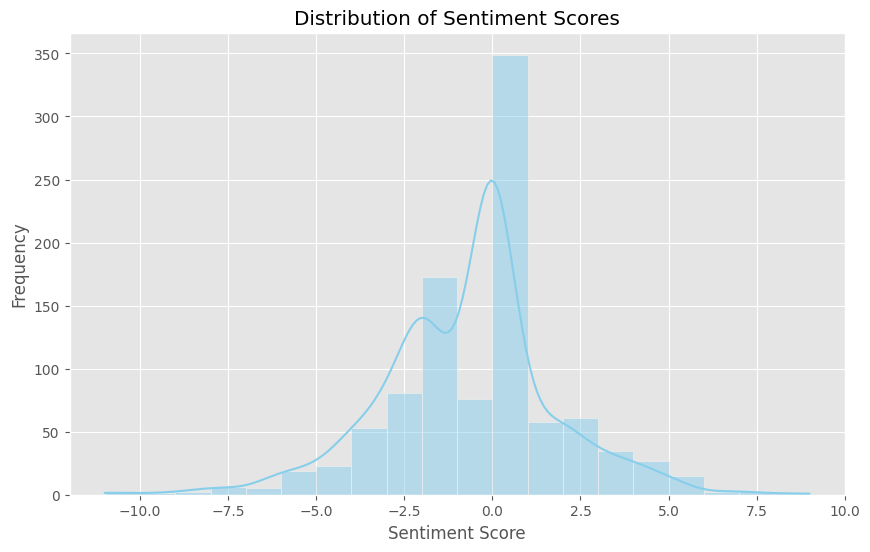

In [20]:
# Plot distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(data['sentiment_score'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.show()

In [21]:
sentiment_counts = data['sentiment_category'].value_counts()


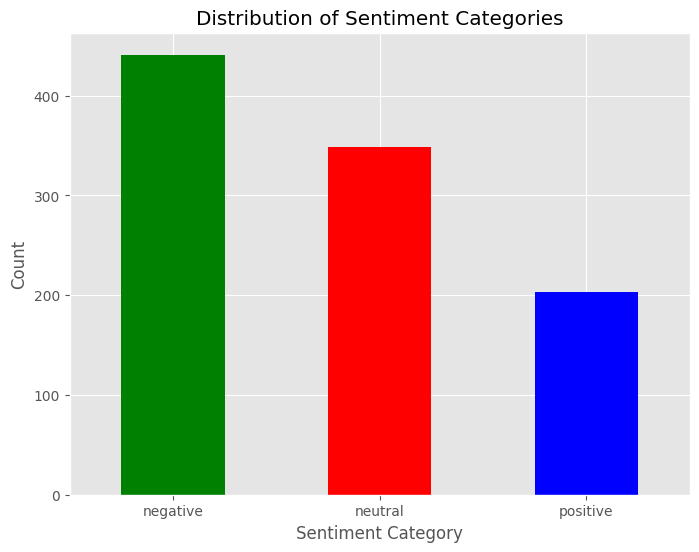

In [22]:
# Plot distribution of sentiment categories
plt.figure(figsize=(8, 6))
sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()

In [26]:
sorted = data.sort_values(by='sentiment_score')
#sorted['cleaned'].head()

In [27]:
#pd.set_option('display.max_colwidth', None)
# print(sorted['post'].head())

In [28]:
#print(sorted['post'].tail(2))

### With TextBlob

In [23]:
from textblob import TextBlob


In [30]:
#data['post']

In [24]:
# compute sentiment scores (polarity) and labels
data['sentiment_score_tb'] = data['cleaned'].apply(lambda x: round(TextBlob(x).sentiment.polarity, 3))
#data['sentiment_score_tb']

#sentiment_scores_tb = [round(TextBlob(article).sentiment.polarity, 3) for article in news_df['clean_text']]


In [25]:
# Add a column 'sentiment_category' based on 'sentiment_score'
data['sentiment_category_tb'] = data['sentiment_score_tb'].apply(lambda x: 'positive' if x > 0 else ('negative' if x < 0 else 'neutral'))
#data['sentiment_category_tb']

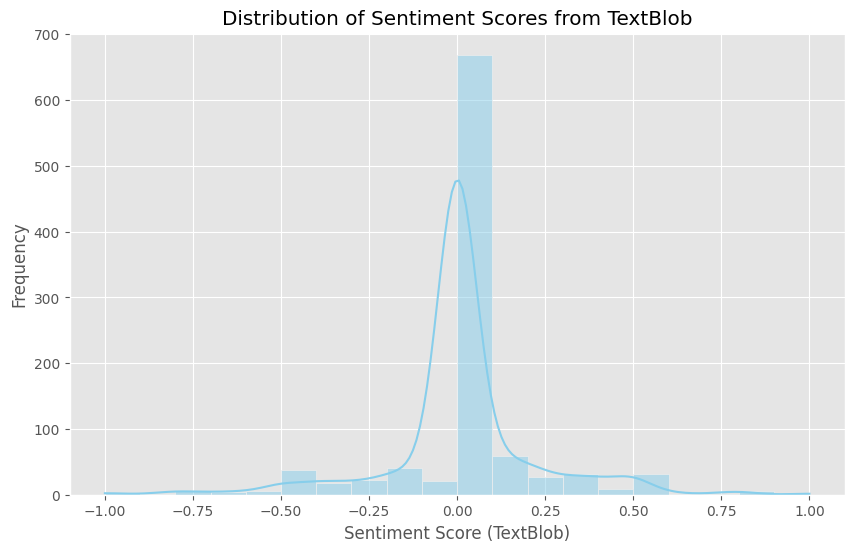

In [26]:
# Plot distribution of sentiment scores
plt.figure(figsize=(10, 6))
sns.histplot(data['sentiment_score_tb'], bins=20, kde=True, color='skyblue')
plt.title('Distribution of Sentiment Scores from TextBlob')
plt.xlabel('Sentiment Score (TextBlob)')
plt.ylabel('Frequency')
plt.show()

In [27]:
sentiment_counts_tb = data['sentiment_category_tb'].value_counts()


In [28]:
sentiment_counts_tb

neutral     611
positive    224
negative    158
Name: sentiment_category_tb, dtype: int64

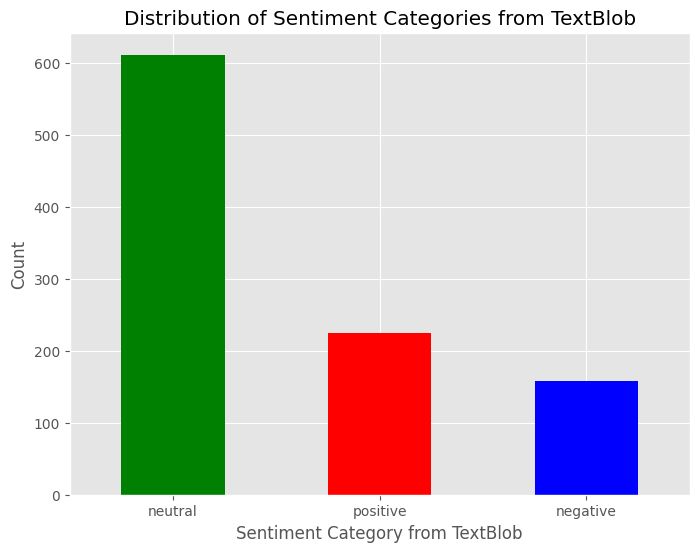

In [29]:
# Plot distribution of sentiment categories
plt.figure(figsize=(8, 6))
sentiment_counts_tb.plot(kind='bar', color=['green', 'red', 'blue'])
plt.title('Distribution of Sentiment Categories from TextBlob')
plt.xlabel('Sentiment Category from TextBlob')
plt.ylabel('Count')
plt.xticks(rotation=0)  # Rotate x-axis labels for better readability
plt.show()

In [37]:
sorted_tb = data.sort_values(by='sentiment_score_tb')
# sorted_tb['cleaned'].head()

In [38]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
 

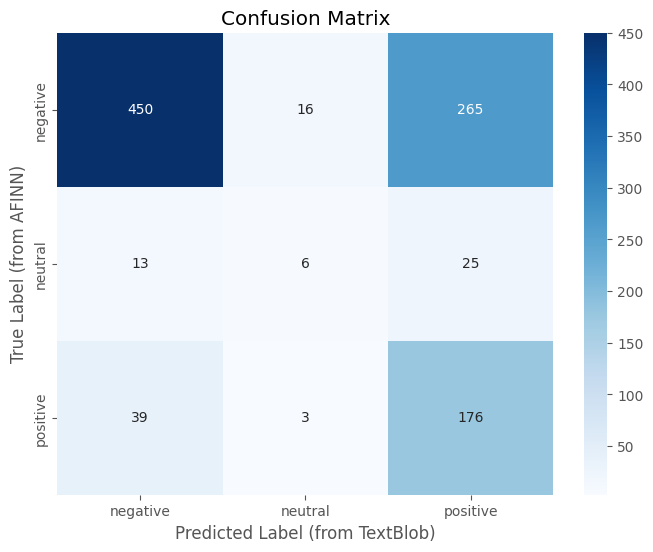

In [39]:
# True labels (ground truth)
true_labels = data['sentiment_category']

# Predicted labels
predicted_labels = data['sentiment_category_tb']  

# Define the list of classes
classes = ['negative', 'neutral', 'positive']

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels, labels=classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label (from TextBlob)')
plt.ylabel('True Label (from AFINN)')
plt.show()

### With VADER

In [40]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm

In [41]:
sia = SentimentIntensityAnalyzer()

In [42]:
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    text = row['cleaned']
    myid = row['id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/993 [00:00<?, ?it/s]

In [43]:
res

{1: {'neg': 0.336, 'neu': 0.483, 'pos': 0.181, 'compound': -0.9934},
 2: {'neg': 0.331, 'neu': 0.591, 'pos': 0.078, 'compound': -0.8658},
 3: {'neg': 0.184, 'neu': 0.715, 'pos': 0.101, 'compound': -0.9608},
 4: {'neg': 0.138, 'neu': 0.695, 'pos': 0.167, 'compound': 0.5204},
 5: {'neg': 0.249, 'neu': 0.751, 'pos': 0.0, 'compound': -0.6486},
 6: {'neg': 0.185, 'neu': 0.725, 'pos': 0.089, 'compound': -0.9687},
 7: {'neg': 0.234, 'neu': 0.436, 'pos': 0.33, 'compound': 0.872},
 8: {'neg': 0.276, 'neu': 0.433, 'pos': 0.291, 'compound': 0.3418},
 9: {'neg': 0.218, 'neu': 0.521, 'pos': 0.261, 'compound': 0.8885},
 10: {'neg': 0.186, 'neu': 0.689, 'pos': 0.125, 'compound': -0.2247},
 11: {'neg': 0.337, 'neu': 0.52, 'pos': 0.143, 'compound': -0.9498},
 12: {'neg': 0.224, 'neu': 0.776, 'pos': 0.0, 'compound': -0.6705},
 13: {'neg': 0.17, 'neu': 0.633, 'pos': 0.196, 'compound': 0.4671},
 14: {'neg': 0.158, 'neu': 0.49, 'pos': 0.352, 'compound': 0.9977},
 15: {'neg': 0.192, 'neu': 0.591, 'pos': 0.2

In [44]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'id'})
vaders = vaders.merge(data, how='left')
# vaders.head()

In [45]:
vaders.columns

Index(['id', 'neg', 'neu', 'pos', 'compound', 'subreddit', 'title', 'selftext',
       'upvote_ratio', 'ups', 'downs', 'score', 'link_flair_css_class',
       'created_utc', 'kind', 'cleaned', 'post', 'sentiment_score',
       'sentiment_category', 'sentiment_score_tb', 'sentiment_category_tb'],
      dtype='object')

In [46]:
test = vaders[['compound','sentiment_score', 'sentiment_score_tb','upvote_ratio', 'ups', 'downs', 'score']] 

In [47]:
test.sort_values(by='ups', ascending=False)

,compound,sentiment_score,sentiment_score_tb,upvote_ratio,ups,downs,score
588,-0.5106,-12.0,0.044,0.97,436,0,436
888,-0.9938,-53.0,-0.108,0.92,231,0,231
163,-0.7316,-2.0,-0.004,0.95,165,0,165
268,-0.9742,-16.0,0.062,0.88,165,0,165
676,0.9604,7.0,0.083,0.98,100,0,100
...,...,...,...,...,...,...,...
953,-0.9893,-18.0,-0.167,0.50,0,0,0
395,-0.9662,-11.0,-0.036,0.50,0,0,0
628,0.9936,31.0,0.277,0.50,0,0,0
862,-0.9930,-38.0,-0.112,0.50,0,0,0


In [48]:
#  # Select relevant columns from the dataframe
# metrics = test[['compound', 'sentiment_score', 'sentiment_score_tb', 'upvote_ratio', 'ups', 'downs', 'score']]
# # Create a pairplot
# sns.pairplot(metrics)
# plt.tight_layout()
# plt.show()

### Roberta Pretrained Model

In [49]:
from transformers import AutoTokenizer

In [50]:
from transformers import AutoModelForSequenceClassification

In [51]:
from scipy.special import softmax

In [52]:
import torch
x = torch.rand(5, 3)
print(x)

tensor([[0.1459, 0.1072, 0.9838],
        [0.4364, 0.9443, 0.7578],
        [0.2439, 0.8277, 0.4530],
        [0.7464, 0.6221, 0.7151],
        [0.5408, 0.2695, 0.9356]])


In [53]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

In [62]:
def polarity_scores_roberta(text, max_length=512):
    # Tokenize the input text using the AutoTokenizer
    inputs = tokenizer(text, return_tensors='pt', max_length=max_length, truncation=True)

   # Check if the input was truncated
    if len(inputs['input_ids'][0]) >= max_length:
        print(f'Warning: Input text truncated for id: {myid}')
        
    # Ensure that 'input_ids' and 'attention_mask' are present in inputs
    if 'input_ids' in inputs and 'attention_mask' in inputs:
        # Call the RoBERTa model
        with torch.no_grad():
            output = model(**inputs)
        scores = output[0][0].detach().numpy()
        scores = softmax(scores, axis=0).tolist()
    
    # Define labels for sentiment classes
        labels = ['negative', 'neutral', 'positive']
        
        # Create a dictionary of sentiment scores
        scores_dict = {f'roberta_{label}': score for label, score in zip(labels, scores)}
        
        return scores_dict
    else:
        raise ValueError('Input tensor dimensions are invalid')

In [54]:
# def polarity_scores_roberta(text):
#     encoded_text = tokenizer(text, return_tensors='pt')
#     output = model(**encoded_text)
#     scores = output[0][0].detach().numpy()
#     scores = softmax(scores)
#     scores_dict = {
#         'roberta_neg' : scores[0],
#         'roberta_neu' : scores[1],
#         'roberta_pos' : scores[2]
#     }
#     return scores_dict

In [63]:
truncated_indices = []
res = {}
for i, row in tqdm(data.iterrows(), total=len(data)):
    try:
        text = row['cleaned']
        myid = row['id']
        
        # Calculate RoBERTa polarity scores
        roberta_result = polarity_scores_roberta(text)
        
        # Process Vader results
        vader_result = sia.polarity_scores(text)
        vader_result_rename = {}
        for key, value in vader_result.items():
            vader_result_rename[f"vader_{key}"] = value
            
        # Combine Vader and RoBERTa results
        both = {**vader_result_rename, **roberta_result}
        res[myid] = both
    except RuntimeError:
        print(f'Broke for id {myid}')
        truncated_indices.append(i)

  0%|          | 0/993 [00:00<?, ?it/s]

In [9]:
def count_words(text):
    return len(text.split())

# Apply the function to each row in the 'cleaned' column
data['word_count'] = data['cleaned'].apply(count_words)

# Sort the DataFrame based on the 'word_count' column in descending order
data_sorted = data.sort_values(by='word_count', ascending=False)

data_sorted

,id,subreddit,title,selftext,upvote_ratio,ups,downs,score,link_flair_css_class,created_utc,kind,cleaned,post,word_count
184,185,mentalhealth,Living with a mentally ill adult who won't get...,***Throwaway because I need this to be anonymo...,1.0,2,0,2,stickied,2024-04-06T11:55:06Z,t3,living mentally ill adult help throwaway need ...,Living with a mentally ill adult who won't get...,739
600,601,mentalhealth,Am I wrong for feeling and thinking this way?,Sorry in advance for the long post. Also Engli...,1.0,1,0,1,,2024-04-04T00:13:07Z,t3,wrong feeling thinking way sorry advance long ...,Am I wrong for feeling and thinking this way? ...,692
656,657,mentalhealth,The amount of rage I have scares me.,This is a throwaway. I'm a 28M and I have so m...,1.0,2,0,2,,2024-04-04T16:06:42Z,t3,amount rage scares throwaway 28m much rage wit...,The amount of rage I have scares me. This is a...,661
97,98,mentalhealth,My PTSD story,My childhood wasn’t some peoples dream childho...,1.0,1,0,1,,2024-04-07T00:48:52Z,t3,ptsd story childhood wasn’t peoples dream chil...,My PTSD story My childhood wasn’t some peoples...,591
396,397,mentalhealth,"Self Taught, not Self Limited",I got my first guitar when I was 8. That was 2...,1.0,3,0,3,,2024-04-05T10:56:09Z,t3,self taught self limited got first guitar 8 22...,"Self Taught, not Self Limited I got my first g...",557
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88,89,mentalhealth,What are signs that someone has deep sadness?,Even if they try and hide it,0.9,15,0,15,,2024-04-07T01:43:28Z,t3,signs someone deep sadness try hide,What are signs that someone has deep sadness? ...,6
293,294,mentalhealth,Is anyone able to chat to me rn?,I wants someone to know how I feel,1.0,2,0,2,stickied,2024-04-05T23:40:32Z,t3,anyone able chat rn wants someone,Is anyone able to chat to me rn? I wants someo...,6
827,828,mentalhealth,PAIN AND CHARACTER,What pain changed you?,1.0,1,0,1,stickied,2024-04-03T22:29:54Z,t3,pain character pain changed you,PAIN AND CHARACTER What pain changed you?,5
290,291,mentalhealth,Tell me why I'm waiting,For someone who couldn't give a fuck about me.,1.0,1,0,1,,2024-04-06T00:00:55Z,t3,tell waiting someone give fuck,Tell me why I'm waiting For someone who couldn...,5


In [10]:
data_sorted['word_count'].head()

184    739
600    692
656    661
97     591
396    557
Name: word_count, dtype: int64

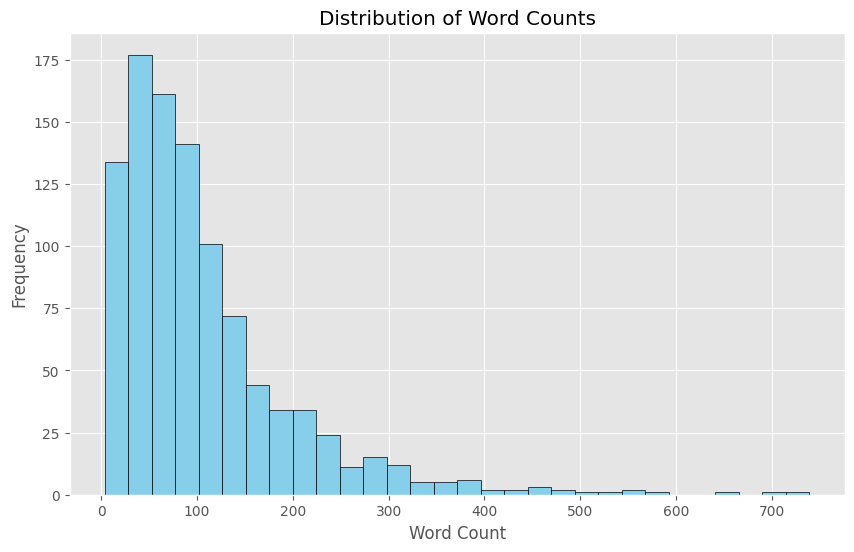

In [11]:
plt.figure(figsize=(10, 6))
plt.hist(data['word_count'], bins=30, color='skyblue', edgecolor='black')
plt.title('Distribution of Word Counts')
plt.xlabel('Word Count')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [12]:
results_df = pd.DataFrame(res).T
results_df = results_df.reset_index().rename(columns={'index': 'id'})
results_df = results_df.merge(data, how='left')

NameError: name 'res' is not defined

Next to try:
1. VADER
2. Naive Bayes: A probabilistic classifier based on Bayes' theorem that is often used for sentiment classification tasks.
3. Support Vector Machines (SVM): A supervised learning algorithm that separates data points into different classes using a hyperplane, commonly used for text classification tasks including sentiment analysis.
4. Recurrent Neural Networks (RNNs): A type of neural network architecture that is well-suited for sequential data such as text. Variants like LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit) are commonly used for sentiment analysis tasks.
5. Convolutional Neural Networks (CNNs): A type of neural network architecture commonly used for image processing tasks, but can also be applied to text classification tasks including sentiment analysis.


- BERT (Bidirectional Encoder Representations from Transformers): A transformer-based model pre-trained on large corpora of text data, which can be fine-tuned for various downstream natural language processing tasks including sentiment analysis.

- GPT (Generative Pre-trained Transformer): Another transformer-based model trained on large-scale text data, known for its ability to generate coherent and contextually relevant text. It can be fine-tuned for sentiment analysis tasks.